# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: January 6, 2024 

Given the analytical equation (fitted empirically) for the Drag Coefficient $C_D$ provided in reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf, we see that it's only a function of the Reynolds number, $Re = \rho.U.D/\mu$. Let's say that we did not know this ahead of time and wanted to perform experiments for a range of input parameters, namely, $\rho$, $U$, $D$, and $\mu$. Clearly, many combinations will be redundant since they correpond to the same $Re$. Consider the following models:  

Given $\rho$, $U$, $D$, and $\mu$, consider the following three models:  


<img src="./Figures/Model_0.png" width="300" height="200" /> . 
<img src="./Figures/Model_I.png" width="300" height="200" /> . 
<img src="./Figures/Model_II.png" width="300" height="200" /> . 

To start, we are interested in the following questions:  
1. Model_0, we fit just to verify that it's an easy regression problem. Note that, given the very large range of inputs spanning multiple orders of magnitute, this is not a trivial problem. So we might choose to limit the range. For example, we expect a linear function for low Re (i.e., Stokes flow), so we could ignore that range. 
2. Assuming we keep the number of trainable parameters approximately the same, is Model_I more data efficient than Model_II, if we randomly sample the 4 parameters?  Intuitively, we expect this to be true since we are biasing the structure of the neural network to discover the existence of an effective compression of the inputs (by $Re$).  
3. After training Model_I, does the single node actually correspond to $Re$? Can the model 'discover' the non-dimensional parameters?  If not, can we somehow help the model to discover this?  
4. (Optional) can we use the knowledge of the $Re$ to perform data augmentation thereby increasing the efficiency of the training? For example, given a combination of inputs, we could generate $n$ additional training samples corresponding to the same $Re$. This 'synthetic data' is expected to improve the efficiency. It is not clear whether this is useful in practice. Still interesting to explore.  


What's on the docket:  
* Verify that MSELoss from PyTorch is consistent with my manual calculation. **DONE**  
* Implement Model_0 to take Re as input and output C_D.  
* Implement Model_I to take the 4 parameters, bottleneck to Re, then output C_D. Is the Re node equal to the value of Re?  
* Quantify data requirements for each model to get similar accuracy? Do we need a hyperparameter optimization for this?  
* Move some sections out of the notebook for more flexibility:
    * Move dataset creation and loading 
    * Move helper functions to utils 
    * Move models 
* Tricks to improve fitting: scale the 4 inputs so that they are roughly in the same range.  
* Limit the range of interest to only include regions with interesting features.  
    


Summary (Jan 1, 2024):  
* The regression for Model_II does not work very well. Ideas to try:
    * Scale inputs to be roughly the same order of magnitude 
    * Shrink the Re range significantly.  
    * Shrink ther anges of input parameters to more reasonable values.  
    * Think more carefully about the sampling and plotting.  
* Fit Re->Cd model. Does it work?





In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


from utils import *
from models import Model_II
from datasets import *

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import torch.nn.init as init
from torch.utils.tensorboard import SummaryWriter

matplotlib.rcParams.update({'font.size': 18})
eps = 1e-12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# def CD_calc(Re=None, U=None, D=None, rho=None, mu=None):
#     """
#     Calculates the the Drag coefficient (CD) and the corresponding Drag force (FD), using the empirical equation found in the
#     reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf

#     Use SI units

#     """
#     if Re is None:
#         Re = rho*U*D/mu

#     CD = (24/Re) \
#         + ((2.6*(Re/5.)) / (1+(Re/5.)**1.52)) \
#         + ((0.411*(Re/2.63e5)**-7.94) / (1 + (Re/2.63e5)**-8.)) \
#         + ((0.25*(Re/1e6)) / (1 + (Re/1e6)))

#     # Calculate FD if U and D and rho are given:
#     if U is not None:
#         FD = CD * (rho*np.pi/8) * (U**2) * (D**2)
#     else:
#         FD = None

#     return CD, FD


# def run_experiments(Re_vec, velocities=None, diameters=None, densities=None, viscosities=None):
#     """
#     Runs the experiment by iterating over the velocity vector or Re_vec and returning the drag coefficient CD and Drag force FD

#     """
#     if Re_vec is not None:
#         CDs, FDs = CD_calc(Re=Re_vec, rho=None, mu=None, U=None, D=None)
#     else:
#         CDs, FDs = CD_calc(Re=None, U=velocities, D=diameters, rho=densities, mu=viscosities)

#     return CDs, FDs


# def plot_CD(Re, CD, marker='o'):
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(6, 6))
#     sns.scatterplot(x=Re, y=CD, color='blue', marker=marker, alpha=0.5)
#     plt.xscale('log')
#     plt.yscale('log')
#     # plt.xlim(1e-1, 1e11)
#     # plt.ylim(1e-2, 1e3)
#     plt.xlabel('$Re$')
#     plt.ylabel('$C_D$')

#     return True

# def generate_inputs_from_Re(Re_vec, u_range, rho_range, mu_range, D_range):
#     """
#     Randomly sample from rho_range, mu_range, and D_range, calculate u, if u is in u_range, 
#     output the parameters, u, rho, mu, D and if not, sample again and repeat. This is used to test inference.
#     """
#     # Generate random samples from the ranges
#     size = len(Re_vec)
#     rho = np.random.uniform(rho_range[0], rho_range[1], size)
#     mu = np.random.uniform(mu_range[0], mu_range[1], size)
#     D = np.random.uniform(D_range[0], D_range[1], size)
#     U = Re_vec * mu / (rho * D)

#     for u in U:
#         if u >= u_range[1] and u <= u_range[0]:
#             print(f"U = {u} is NOT in range")

#     return rho, mu, D, U

In [2]:
Re_vec = np.logspace(2, 7, 1000)
rho, mu, D, U = generate_inputs_from_Re(Re_vec=Re_vec, u_range=[0.1, 1e3], rho_range=[1, 1000], mu_range=[1e-3, 1e3], D_range=[1e-3, 1e3])
# rho# 

True

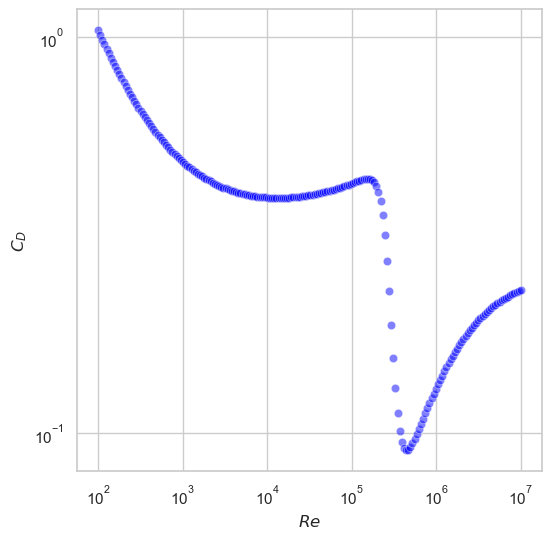

In [3]:
Re_vec = np.logspace(2, 7, 200)
CDs, _ = run_experiments(Re_vec=Re_vec)
plot_CD(Re_vec, CDs, marker='o')

## Models

In [ ]:
# Model_II
class Model_II(nn.Module):
    def __init__(self, input_dim=4 , output_dim= 1, hidden_dims=[32, 16, 8, 4]):
        super(Model_II, self).__init__()
        hidden_dims.insert(0, input_dim)
        hidden_dims.append(output_dim)
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
            self.layers.append(layer)

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            # x = torch.relu(self.layers[i](x))
            x = F.leaky_relu(self.layers[i](x), 0.1)
            # x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)  # Apply the last layer without ReLU
        return x

# Model_II with BatchNorm
# class Model_II(nn.Module):
#     def __init__(self, input_dim=4, output_dim=1, hidden_dims=[32, 16, 8, 4]):
#         super(Model_II, self).__init__()
#         hidden_dims.insert(0, input_dim)
#         hidden_dims.append(output_dim)
#         self.layers = nn.ModuleList()
#         self.batch_norms = nn.ModuleList()

#         for i in range(len(hidden_dims) - 1):
#             self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
#             # Add BatchNorm layer for each hidden layer, but not for the output layer
#             if i < len(hidden_dims) - 2:
#                 self.batch_norms.append(nn.BatchNorm1d(hidden_dims[i+1]))

#     def forward(self, x):
#         for i in range(len(self.layers) - 1):
#             x = self.layers[i](x)
#             x = self.batch_norms[i](x)
#             x = F.leaky_relu(x, 0.1)

#         x = self.layers[-1](x)  # Apply the last layer without ReLU
#         return x

## Dataset Creation

In [ ]:
# Data Generation:
# Let's first generate random samples of rho, mu, D, and U. The true label is then calculated using the run_experiments function. 
# The Reynolds numbers are also calculated and returned as a vector for convenience.
def sample_parameters_naive(num_samples=100000, Re_range = None, rho_range=[500, 3000], mu_range=[0.3e-3, 0.1], D_range=[0.05, 1], U_range=[1, 10], seed=123):
    if seed is not None:
        np.random.seed(seed)
        
    rho = np.random.uniform(rho_range[0], rho_range[1], num_samples)
    mu = np.random.uniform(mu_range[0], mu_range[1], num_samples)
    D = np.random.uniform(D_range[0], D_range[1], num_samples)
    U = np.random.uniform(U_range[0], U_range[1], num_samples)

    # Calculate the true CD and FD:
    CD, _ = run_experiments(Re_vec=None, velocities=U, diameters=D, densities=rho, viscosities=mu)
    Re_vec = rho * U * D / mu
    return rho, mu, D, U, Re_vec, CD

def sample_parameters(num_samples=100000, Re_range=[1e2, 3e7], rho_range=[500, 3000], mu_range=[0.3e-3, 0.1], D_range=[0.05, 1], U_range=[1, 10], seed=123):
    if seed is not None:
        np.random.seed(seed)

    rho = np.zeros(num_samples)
    mu = np.zeros(num_samples)
    D = np.zeros(num_samples)
    U = np.zeros(num_samples)

    # Step 1: Uniformly sample Re
    # Re_vec = np.random.uniform(Re_range[0], Re_range[1], num_samples)
    # Sample uniformly in log space
    Re_vec = np.exp(np.random.uniform(np.log(Re_range[0]), np.log(Re_range[1]), num_samples))

    # Parameters to choose from
    param_choices = ['rho', 'mu', 'D', 'U']

    for i in range(num_samples):
        # Step 2: Randomly choose which 3 parameters to sample
        sampled_params = np.random.choice(param_choices, 3, replace=False)

        if 'rho' in sampled_params:
            rho[i] = np.random.uniform(rho_range[0], rho_range[1])
        if 'mu' in sampled_params:
            mu[i] = np.random.uniform(mu_range[0], mu_range[1])
        if 'D' in sampled_params:
            D[i] = np.random.uniform(D_range[0], D_range[1])
        if 'U' in sampled_params:
            U[i] = np.random.uniform(U_range[0], U_range[1])

        # Step 3: Calculate the fourth parameter
        if 'rho' not in sampled_params:
            rho[i] = Re_vec[i] * mu[i] / (U[i] * D[i])
        elif 'mu' not in sampled_params:
            mu[i] = Re_vec[i] / (rho[i] * U[i] * D[i])
        elif 'D' not in sampled_params:
            D[i] = Re_vec[i] * mu[i] / (rho[i] * U[i])
        elif 'U' not in sampled_params:
            U[i] = Re_vec[i] * mu[i] / (rho[i] * D[i])

        # Step 4: Validate and adjust
        rho[i] = np.clip(rho[i], rho_range[0], rho_range[1])
        mu[i] = np.clip(mu[i], mu_range[0], mu_range[1])
        D[i] = np.clip(D[i], D_range[0], D_range[1])
        U[i] = np.clip(U[i], U_range[0], U_range[1])

    # Step 5: Calculate the true CD using the run_experiments function
    CD, _ = run_experiments(Re_vec=Re_vec, velocities=None, diameters=None, densities=None, viscosities=None)

    return rho, mu, D, U, Re_vec, CD


class RandomDataset(Dataset):
    def __init__(self, num_samples=100000, Re_range= [1e2, 3e7] ,rho_range=[100, 2000], mu_range=[0.001, 0.01], D_range=[0.05, 0.5], U_range=[0.1, 20], seed=None):
        self.rho, self.mu, self.D, self.U, self.Re, self.CD = sample_parameters(num_samples=num_samples, Re_range=Re_range, rho_range=rho_range, mu_range=mu_range, D_range=D_range, U_range=U_range, seed=seed)
        # self.rho, self.mu, self.D, self.U, self.Re, self.CD = sample_parameters_naive(num_samples=num_samples, Re_range=None, rho_range=rho_range, mu_range=mu_range, D_range=D_range, U_range=U_range, seed=seed)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        input_sample = np.array([self.rho[idx], self.mu[idx], self.D[idx], self.U[idx]], dtype=np.float32)
        target = np.array([self.CD[idx]], dtype=np.float32)
        return input_sample, target

# Used for verifying results later:    
def extract_Re_values(dataset, subset):
    return [dataset.Re[idx] for idx in subset.indices]



# Create the dataloader/dataset:
dataset = RandomDataset(num_samples=500000, 
                        Re_range=[1e5, 1e7], 
                        rho_range=[100, 3000], 
                        mu_range=[0.3e-3, 0.1], 
                        D_range=[0.05, 1], 
                        U_range=[1, 10], 
                        seed=1234)


# Split the dataset into train, validation, and test sets:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0) #TODO: Change num_workers to 4. Need to take RandomDataset out of the main function
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0)

# Extract Re values for test set:
train_Re = extract_Re_values(dataset, train_dataset)
val_Re = extract_Re_values(dataset, val_dataset)
test_Re = extract_Re_values(dataset, test_dataset)


In [ ]:
# rho, mu, D, U, Re_vec, CD = sample_parameters(num_samples=1000, 
#                                               Re_range=[1e0, 3e7], 
#                                               rho_range=[50, 3000], 
#                                               mu_range=[0.3e-3, 5], 
#                                               D_range=[0.05, 10], 
#                                               U_range=[.001, 10])

# plt.loglog(Re_vec, CD, 'o', alpha=0.5)

In [ ]:
plt.hist(test_Re, bins=10, edgecolor='black')
plt.xlabel('Reynolds Number (Re)')
plt.ylabel('Frequency')
plt.title('Histogram of Reynolds Numbers in Test Dataset')
plt.show()

min(test_Re), max(test_Re)

# Training

In [ ]:
# Setting up the model:
HIDDEN_DIMS = [256, 128, 64, 32, 32, 32, 16, 8, 4]
model = Model_II(input_dim=4, output_dim=1, hidden_dims=HIDDEN_DIMS)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

model = model.float()
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter('runs/Model_II')

NUM_EPOCHS = 1000

In [ ]:
# Used to save the best model:
best_val_loss = float('inf')
best_model_state = None

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    writer.add_scalar('Loss/Train', train_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    tqdm.write(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Test loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
writer.add_scalar('Loss/Test', test_loss, NUM_EPOCHS)

tqdm.write(f'Final Test Loss: {test_loss:.4f}')

# Save the best model:
torch.save(best_model_state, 'models/Model-II-checkpoint.pth')
writer.close()

## Inference & Testing:  
Visualize the model fit by looking at the curves for a regularly-spaced Re vector covering the entire range.

In [ ]:
def infer_cd_from_re(re_vector, model_path, hidden_dims = HIDDEN_DIMS, inputs=None):
    # HIDDEN_DIMS = [256, 256, 64, 32] #TODO: add this as a parameter to this function
    model = Model_II(input_dim=4, output_dim=1, hidden_dims=[256, 128, 64, 32, 32, 32, 16, 8, 4])
    model_checkpoint = torch.load(model_path)
    model.load_state_dict(model_checkpoint)
    model.eval()

    # Check if inputs are provided or need to be generated
    if inputs is None:
        # Generate inputs from Re vector
        rho, mu, D, U = generate_inputs_from_Re(Re_vec=re_vector,  # Corrected variable name
                                                u_range=[0.01, 20],
                                                rho_range=[10, 2000],
                                                mu_range=[1e-3, 0.1],
                                                D_range=[0.05, 0.5])
        input_tensor = torch.tensor(np.column_stack((rho, mu, D, U)), dtype=torch.float32)
    else:
        test_inputs = []
        for idx in range(len(inputs)):
            input_sample, _ = inputs[idx]  # Get the input sample and ignore the target
            test_inputs.append(input_sample)  # Convert to numpy if it's a tensor

        # Convert list to numpy array and then to tensor
        input_tensor = torch.tensor(np.stack(test_inputs), dtype=torch.float32)

    # Perform inference
    with torch.no_grad():
        cd_predicted = model(input_tensor).squeeze().numpy()

    return cd_predicted



### Method #1:

In [ ]:
rho, mu, D, U, Re_vec, CD = sample_parameters_naive(num_samples=5000,
                                              Re_range=None,
                                              rho_range=[10, 2000],
                                              mu_range=[0.001, 0.1],
                                              D_range=[0.05, 0.5],
                                              U_range=[0.01, 20])

cd_predicted = infer_cd_from_re(re_vector=Re_vec, model_path='models/Model-II-checkpoint.pth')
cd_true = CD

plt.figure(figsize=(10, 6))

plt.scatter(Re_vec, cd_predicted, color='red',
            label='CD Predicted', marker='x')
plt.scatter(Re_vec, cd_true, color='blue', label='CD True', marker='o')
plt.xscale('log')
plt.yscale('log')


plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient (CD)')
plt.title('Comparison of True and Predicted CD values')
plt.legend()
plt.show()

mse_error = np.mean((cd_true - cd_predicted)**2)
print("MSE:", mse_error)

In [ ]:
Re_vec[0:10]

### Method #2:

In [ ]:
# Testing:
# Generate a random Re vector:
Re_vec = np.array(train_Re) #np.logspace(2, 7, 200)
# Re_vec = np.logspace(-1, 11, 5000)
# Infer the CD from the Re vector:
cd_predicted = infer_cd_from_re(Re_vec, model_path='models/Model-II-checkpoint.pth', inputs=train_dataset)
cd_true, _ = run_experiments(Re_vec=Re_vec)

plt.figure(figsize=(10, 6))

# Plotting predicted CD values
plt.scatter(Re_vec, cd_predicted, color='red', label='CD Predicted', marker='x', alpha=0.5)
plt.scatter(Re_vec, cd_true, color='blue', label='CD True', marker='o', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient (CD)')
plt.title('Comparison of True and Predicted CD values')
plt.legend()
plt.show()


mse_error = np.mean((cd_true - cd_predicted)**2)
print("MSE:", mse_error)
r2 = 1 - np.sum((cd_true - cd_predicted)**2) / np.sum((cd_true - np.mean(cd_true))**2)
print("R2:", r2)


plt.hist(Re_vec, bins=10, edgecolor='black')
plt.xlabel('Reynolds Number (Re)')
plt.ylabel('Frequency')
plt.title('Histogram of Reynolds Numbers in Test Dataset')
plt.show()


In [ ]:
min(Re_vec)